In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
import keras
import seaborn as sns
sns.set()

**Read data and transform them to pandas dataframe**

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/NYSE-STOCK_MARKET-ANALYSIS-USING-LSTM/master/nyse/prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [4]:
df2 = pd.read_csv("https://raw.githubusercontent.com/ashishpatel26/NYSE-STOCK_MARKET-ANALYSIS-USING-LSTM/master/nyse/fundamentals.csv")
df2.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,1.049900e+10,78.0,0.000000e+00,223000000.0,1.001000e+09,-1.813000e+09,-2.445000e+09,0.0,0.0,1.340200e+10,0.000000e+00,58.0,1.435600e+10,-5.690000e+08,8.690000e+08,632000000.0,5.800000e+08,3.060000e+08,4.730000e+08,7.116000e+09,0.0,0.0,0.0,-1.020000e+09,197000000.0,1.285000e+09,4.830000e+08,-1.571000e+09,-1.876000e+09,2.050000e+09,-1.876000e+09,-4.084000e+09,1.124000e+09,3.860000e+08,1.480000e+08,1.0,2.167000e+09,6.260000e+08,4.524000e+09,-2.980000e+09,1.509000e+09,11000000.0,1.514700e+10,-141000000.0,8.450000e+08,10.0,31.0,8.0,72.0,0.0,-9.462000e+09,0.000000e+00,1.297700e+10,1.419000e+09,3.412000e+09,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,1.101900e+10,104.0,0.000000e+00,935000000.0,1.020000e+09,-1.324000e+09,-2.180000e+09,0.0,0.0,1.925900e+10,4.086000e+09,59.0,1.572400e+10,-3.460000e+08,2.311000e+09,856000000.0,1.012000e+09,-1.181000e+09,-2.350000e+08,1.535300e+10,0.0,0.0,0.0,2.208000e+09,660000000.0,6.750000e+08,3.799000e+09,-3.814000e+09,-1.834000e+09,1.873000e+09,-1.834000e+09,-4.489000e+09,1.560000e+09,5.590000e+08,1.399000e+09,5.0,2.299000e+09,1.465000e+09,7.385000e+09,-2.032000e+09,1.711000e+09,481000000.0,1.491500e+10,-56000000.0,8.530000e+08,8.0,80.0,7.0,96.0,0.0,-1.129600e+10,0.000000e+00,1.291300e+10,1.446000e+09,8.111000e+09,4.227800e+10,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,1.562000e+10,88.0,0.000000e+00,829000000.0,1.342000e+09,4.099000e+09,3.212000e+09,0.0,0.0,2.308400e+10,4.091000e+09,63.0,2.703000e+10,3.300000e+08,2.240000e+09,887000000.0,1.004000e+09,1.799000e+09,-1.026000e+09,1.604300e+10,0.0,0.0,0.0,1.700000e+08,-146000000.0,3.080000e+09,-3.150000e+08,-2.911000e+09,2.882000e+09,5.420000e+08,2.882000e+09,2.882000e+09,1.771000e+09,8.000000e+08,4.249000e+09,10.0,2.060000e+09,8.980000e+08,7.059000e+09,-4.559000e+09,8.170000e+08,601000000.0,1.092800e+10,-500000000.0,1.295000e+09,8.0,159.0,7.0,80.0,0.0,-8.562000e+09,-1.052000e+09,2.068600e+10,1.677000e+09,6.309000e+09,4.322

**Extract all symbols from the list**

In [5]:
symbols = list(set(df.symbol))
len(symbols)

501

In [6]:
symbols[:11]

['ES', 'NLSN', 'PNW', 'SYY', 'NTRS', 'MTB', 'HP', 'DPS', 'NFLX', 'MON', 'MUR']

In [7]:
df = df[df.symbol == 'GOOG']
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,312.304948,310.955001,313.580158,3927000.0,312.205308
2010-01-05,312.419511,309.610028,312.748278,6031900.0,310.830459
2010-01-06,311.761979,302.048370,311.761979,7987100.0,302.994813
2010-01-07,303.562685,295.218951,303.861575,12876600.0,295.941242
2010-01-08,294.895159,293.455551,300.499172,9483900.0,299.886470


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1762 non-null   float64
 1   low        1762 non-null   float64
 2   high       1762 non-null   float64
 3   volume     1762 non-null   float64
 4   adj close  1762 non-null   float64
dtypes: float64(5)
memory usage: 82.6+ KB


In [9]:
df.plot(figsize=(23,8),title = "Google Stock Price Analysis")
plt.subplot(411)
plt.plot(df.open, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(df.low, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(df.high,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(df.volume, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

KeyboardInterrupt: ignored

**Normalize the data**

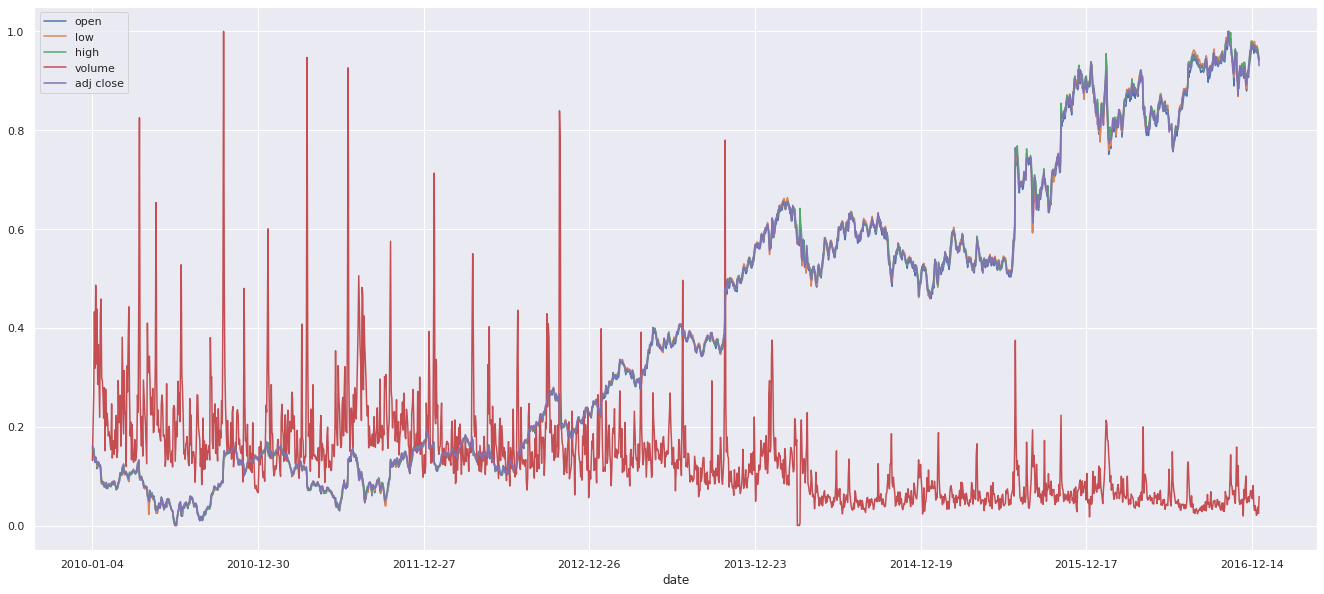

KeyboardInterrupt: ignored

In [10]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.plot(figsize=(23,10))
plt.show()
plt.subplot(411)
plt.plot(df.open, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(df.low, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(df.high,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(df.volume, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**Create Training Set and Testing Set**

In [15]:
del df['volume']
def load_data(stock, window):
    data = stock.to_numpy() 
    result = []
    
    for index in range(len(data) - window): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + window]) # index : index + n days
    
    result = np.array(result).reshape(4*window, -1)
    row = round(0.9 * result.shape[1]) # 90% split
    
    x_train = result[:, :int(row)] 
    y_train = data[window:window+int(row),3].reshape(-1, 1)
    
    x_test = result[:, int(row):] 
    y_test = data[window+int(row):,3].reshape(-1, 1)  

    return [x_train, y_train, x_test, y_test]

In [16]:
x_train, y_train, x_test, y_test = load_data(df.iloc[:1760,:], 10)

In [20]:
x_train.shape
y_train.shape

(1575, 1)

## **Build the structure of model**  
 
* **epochs** = 10000  
* **DNN** 256  

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [49]:
model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_shape=(40,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                410       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(loss='mse',
              optimizer = optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])

In [52]:
hist = model.fit(x_train.T, y_train, batch_size=x_train.size, epochs=10000, validation_data=(x_test.T, y_test))

Streaming output truncated to the last 5000 lines.
Epoch 7501/10000
1/1 [==============================] - 0s 26ms/step - loss: 0.0463 - accuracy: 6.3492e-04 - val_loss: 0.2300 - val_accuracy: 0.0000e+00
Epoch 7502/10000
1/1 [==============================] - 0s 26ms/step - loss: 0.0462 - accuracy: 6.3492e-04 - val_loss: 0.2299 - val_accuracy: 0.0000e+00
Epoch 7503/10000
1/1 [==============================] - 0s 26ms/step - loss: 0.0462 - accuracy: 6.3492e-04 - val_loss: 0.2299 - val_accuracy: 0.0000e+00
Epoch 7504/10000
1/1 [==============================] - 0s 27ms/step - loss: 0.0462 - accuracy: 6.3492e-04 - val_loss: 0.2298 - val_accuracy: 0.0000e+00
Epoch 7505/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.0462 - accuracy: 6.3492e-04 - val_loss: 0.2298 - val_accuracy: 0.0000e+00
Epoch 7506/10000
1/1 [==============================] - 0s 64ms/step - loss: 0.0462 - accuracy: 6.3492e-04 - val_loss: 0.2298 - val_accuracy: 0.0000e+00
Epoch 7507/10000
1/1 [=========

## Build the Convolution Neural Network

epochs = 200

In this part we will build a Convolution Neural Network(CNN). CNNs are usually used for visual images and categorizations, however it could be used in the regression cases like this. In order to use the CNN, we need to change the shape of our input and output values, and then redo the train-test split. 

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [34]:
stock = df.iloc[:1760,:]
window = 10

data = stock.to_numpy() 
result = []
    
for index in range(len(data) - window): # maxmimum date = lastest date - sequence length
    result.append(data[index: index + window]) # index : index + n days
    
result = np.array(result).reshape(4*window, -1)

x = result.T
y = data[window:,3]

print(x.shape)
print(y.shape)

(1750, 40)
(1750,)


Here we can see that our feature data is at shape (1750, 40), which is a two dimensional. It represents 1750 observations and 40 variables. To make regression predictions in CNN, we need to use the Conv 1d model in Keras. Thus we need to make the input one dimentional. To do that, we can add a dimention and treat the whole data as a single input row. 

In [36]:
x = x.reshape(x.shape[0], x.shape[1], 1)
print(x.shape)

(1750, 40, 1)


Then, we can test-train split the data again, using the 90% cut-off.

In [37]:
x_train_cnn, x_test_cnn, y_train_cnn, y_test_cnn=train_test_split(x, y, test_size=0.1) 
print(x_train_cnn.shape)
print(x_test_cnn.shape)
print(y_train_cnn.shape)
print(y_test_cnn.shape)

(1575, 40, 1)
(175, 40, 1)
(1575,)
(175,)


Now with the new data shape, we can create the 1-d convolution model and fit the train data. 

- First we add a Conv1D layer, the input shape is (40, 1) because we have reshaped the data to be a single input row. It uses ReLU as activation function. 
- Then we use a flatten layer to flatten the data for further calculation
- Then we add a dense layer with ReLU.
- Finally we compile the model and calculate the loss with ADAM optimizer. 


In [53]:
model = Sequential()
model.add(Conv1D(32, 2, activation="relu", input_shape=(40, 1)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(1))
model.summary()

model.compile(loss="mse", optimizer="adam")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 39, 32)            96        
_________________________________________________________________
flatten_2 (Flatten)          (None, 1248)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                79936     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 80,097
Trainable params: 80,097
Non-trainable params: 0
_________________________________________________________________


After creating the model, we can fit and predict it with our trainning data. 

In [56]:
hist = model.fit(x_train_cnn, y_train_cnn, batch_size=12,epochs=200, validation_data=(x_test_cnn, y_test_cnn))

Epoch 1/200
132/132 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 2/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 3/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 4/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 5/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 6/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 7/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 8/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 9/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 10/200
132/132 [==============================] - 0s 2ms/step - loss: 0.0023 - val_lo

In [57]:
y_pred_cnn = model.predict(x_test_cnn)

50/50 [==============================] - 0s 1ms/step - loss: 0.0019
0.0019289364572614431
MSE: 0.0031


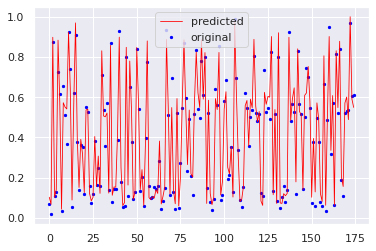

In [58]:
print(model.evaluate(x_train_cnn, y_train_cnn))
 
print("MSE: %.4f" % mean_squared_error(y_test_cnn, y_pred_cnn))

x_ax = range(len(y_pred_cnn))
plt.scatter(x_ax, y_test_cnn, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred_cnn, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

The result from CNN model is very good, with a MSE of 0.3%. The plot of original VS predicted is at above.